## Quick Start with CLIPUNETR
This is a notebook that quickly shows how to run CLIPUNETR model for referring expression segmentation.

### Preparations
First install `CLIPUNETR` in your environment following the [installation instructions](https://github.com/cjiang2/clipunetr#installation) in the repo. 

In [7]:
from typing import List
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")
from clipunetr.models import CLIPUNETR, tokenize
from clipunetr.utils import cvtransforms

In [ ]:
# Download the demo weights and put under "<repo>/checkpoints"
!pip install gdown
!gdown https://drive.google.com/u/1/uc?id=1nejrO8vUpW52n5iQU93oTfUq5DnxA_Ma
!mkdir ../checkpoints
!mv ViT-B-16_clipunetr_c64.pt ../checkpoints/ViT-B-16_clipunetr_c64.pt

In [9]:
def normalize_preds(
    x: torch.Tensor,
    ) -> torch.Tensor:
    """Batch-wise normalization for predicted masks. 
    """
    assert len(x.shape) == 3
    ma = torch.amax(x, dim=(1, 2), keepdims=True)
    mi = torch.amin(x, dim=(1, 2), keepdims=True)
    y = (x - mi) / (ma - mi)
    return y

def visualize_preds(
    img: np.ndarray,
    preds: np.ndarray,
    prompts: List[str],
    ):
    # Visualize prediction
    n = len(prompts) + 1
    _, ax = plt.subplots(1, n, figsize=(4*n, n))
    [a.axis('off') for a in ax.flatten()]
    ax[0].imshow(img)
    for i in range(1, n):
        ax[i].imshow(preds[i-1], cmap="gray")
        ax[i].text(0, -15, prompts[i-1])
    plt.show()

### Load the model

In [10]:
backbone = "ViT-B/16"
channels = [64, 64, 64, 64]
ckpt_file = ""
n_px = 336

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPUNETR(channels=channels)
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load("../checkpoints/ViT-B-16_clipunetr_c64.pt", map_location=device), strict=False)
model.eval()

preprocess = cvtransforms._transform_clipunetr(n_px)

### Inference with CLIPUNETR
CLIPUNETR segments region given a referring expression. We take a few example images. 

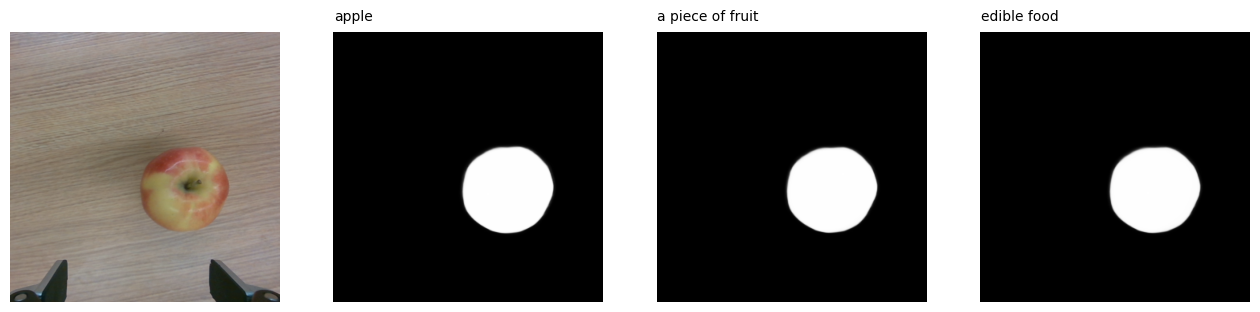

In [11]:
# Inference for img1
img1 = cv2.cvtColor(cv2.imread("images/apple_gen3.png"), cv2.COLOR_BGR2RGB)
prompts_1 = ["apple", "a piece of fruit", "edible food"]

x1 = preprocess(img1)
x1 = x1.repeat(len(prompts_1), 1, 1, 1)
z1 = tokenize(prompts_1)
if torch.cuda.is_available():
    x1 = x1.cuda()
    z1 = z1.cuda()

with torch.no_grad():
    outputs = model(x1, z1)
    preds = outputs[-1].squeeze(1)     # Take only S_fuse: (bs, H, W)

# Post-processing
preds = normalize_preds(preds)
preds = np.uint8(255 * preds.cpu().numpy())
visualize_preds(img1, preds, prompts_1)

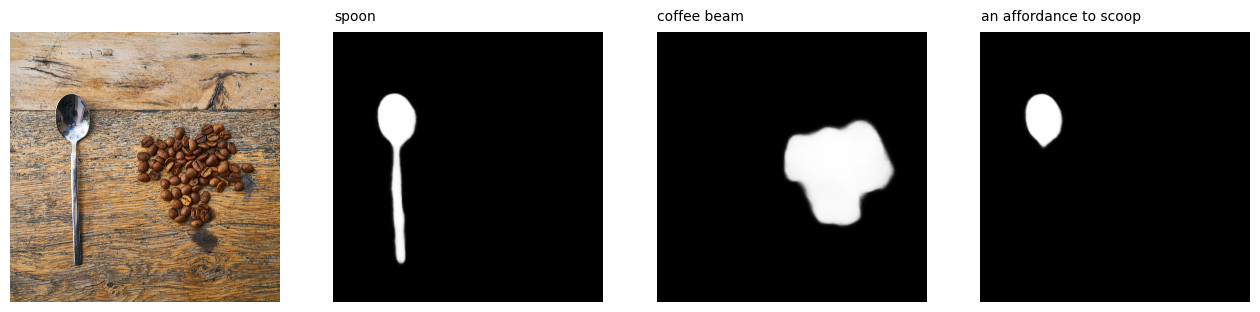

In [12]:
# Inference for img2
img2 = cv2.cvtColor(cv2.imread("images/spoon_and_coffee_beam.jpg"), cv2.COLOR_BGR2RGB)
prompts_2 = ["spoon", "coffee beam", "an affordance to scoop"]

x2 = preprocess(img2)
x2 = x2.repeat(len(prompts_2), 1, 1, 1)
z2 = tokenize(prompts_2)
if torch.cuda.is_available():
    x2 = x2.cuda()
    z2 = z2.cuda()

with torch.no_grad():
    outputs = model(x2, z2)
    preds = outputs[-1].squeeze(1)     # Take only S_fuse: (bs, H, W)

# Post-processing
preds = normalize_preds(preds)
preds = np.uint8(255 * preds.cpu().numpy())
visualize_preds(img2, preds, prompts_2)